# Graph Ektraksi Kata

## Crawl Detik

Program ini, "Detik News Scraper", dirancang untuk mengambil informasi dari situs detik.com terkait topik berita yang diinginkan. Pengguna memasukkan topik, program mengambil URL berita, dan kemudian ekstrak informasi seperti judul, penulis, tanggal, dan isi berita.

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json

class Detik:
    def __init__(self, topic):
        self.topic = topic
        self.df = None  # Inisialisasi DataFrame sebagai None

    def get_urls(self):
        news_links = []
        # get news URL from page 1
        page = 1
        url = f"https://www.detik.com/search/searchall?query={self.topic}&siteid=2&sortby=time&page={page}"
        html_page = requests.get(url).content
        soup = BeautifulSoup(html_page, 'lxml')
        articles = soup.find_all('article')

        # Ambil hanya satu URL berita, jika ada
        if articles:
            url = articles[0].find('a')['href']
            news_links.append(url)

        return news_links

    def has_link(self, text):
        # Fungsi untuk memeriksa apakah teks mengandung tautan
        return 'href=' in text

    def extract_news(self):
        # get news article details from scraped URLs
        scraped_info = []
        for news in self.get_urls():
            source = news
            html_page = requests.get(news).content
            soup = BeautifulSoup(html_page, 'lxml')
            # check if title, author, date, news div, is not None type
            title = soup.find('h1', class_='detail__title')
            if title is not None:
                title = title.text
                title = title.replace('\n', '')
                title = title.strip()

            author = soup.find('div', class_='detail__author')
            if author is not None:
                author = author.text

            date = soup.find('div', class_='detail__date')
            if date is not None:
                date = date.text

            # Ambil isi berita dari div dengan class 'detail__body-text itp_bodycontent'
            content_div = soup.find("div", {"class": "detail__body-text itp_bodycontent"})
            if content_div:
                # Hilangkan elemen-elemen <a> yang merupakan tautan
                for a_tag in content_div.find_all(self.has_link):
                    a_tag.decompose()

                # Ambil teks dari div
                news_content = ' '.join(content_div.stripped_strings)

                # convert scraped data into a dictionary
                news_data = {
                    "url": source,
                    "judul": title,
                    "penulis": author,
                    "tanggal": date,
                    "isi": news_content
                }
                # add dictionaries to a list
                scraped_info.append(news_data)

        self.df = pd.DataFrame.from_dict(scraped_info)
        self.df.to_csv(f'{self.topic}.csv', index=False)  # Simpan DataFrame ke dalam file CSV

# Input topik berita
topic = input("Masukkan topik berita yang ingin diambil: ")
detik_crawler = Detik(topic)
detik_crawler.extract_news()

# Setelah DataFrame df dibuat dalam metode extract_news, Anda dapat mengaksesnya di sini
detik_crawler.df



Masukkan topik berita yang ingin diambil: olahraga


,url,judul,penulis,tanggal,isi
0,https://www.detik.com/sumut/berita/d-7059118/1...,"12 Tanda Tubuh Perlu Diet, Perut Buncit dan Mu...",Tim detikHealth - detikSumut,"Selasa, 28 Nov 2023 08:00 WIB",Daftar Isi 12 Tanda Tubuh Harus Segera Diet 1....


## Ekstraksi kata

 fungsi build_co_occurrence_matrix, kata-kata yang muncul bersamaan dalam jendela setiap kata direkam dalam matriks co-occurrence. Nilai dalam matriks menunjukkan seberapa sering kata-kata tersebut muncul bersamaan.

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Download stopwords dataset
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    # Hapus simbol dan angka menggunakan regular expression
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenisasi kata-kata
    words = word_tokenize(text)

    # Hapus stopwords
    words = [word for word in words if word.lower() not in stop_words]

    # Gabungkan kembali kata-kata yang sudah diolah
    processed_text = ' '.join(words)

    return processed_text

def build_co_occurrence_matrix(corpus, window_size):
    # Build unique words
    unique_words = set()
    for text in corpus:
        text = preprocess_text(text)
        for word in word_tokenize(text):
            unique_words.add(word)

    word_search_dict = {word: np.zeros(shape=(len(unique_words))) for word in unique_words}
    word_list = list(word_search_dict.keys())
    for text in corpus:
        text = preprocess_text(text)
        text_list = word_tokenize(text)
        for idx, word in enumerate(text_list):
            # Pick word in the size range
            i = max(0, idx - window_size)
            j = min(len(text_list) - 1, idx + window_size)
            search = [text_list[idx_] for idx_ in range(i, j + 1)]
            search.remove(word)
            for neighbor in search:
                # Get neighbor idx in word_search_dict
                nei_idx = word_list.index(neighbor)
                word_search_dict[word][nei_idx] += 1
    return word_search_dict


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# Ambil kolom 'isi' dari DataFrame sebagai corpus
corpus = detik_crawler.df['isi'].tolist()

# Tampilkan contoh dari corpus
print(corpus[:5])

['Daftar Isi 12 Tanda Tubuh Harus Segera Diet 1. Perut Buncit 2. Pakaian Mulai Sesak 3. Nyeri Sendi 4. Sesak Napas 5. Lebih Mudah Lapar 6. Tidur Sering Mendengkur 7. Perut Sering Mulas 8. Muncul Masalah Kulit 9. Tekanan Darah Tinggi 10. Perhatikan Lingkar Pinggang 11. Punya Berat Badan Berlebih 12. Mudah Lelah Medan - Perut mulai buncit, pakaian sesak, dan mudah lelah menjadi salah tanda tubuh perlu diet. Jika terus dibiarkan, berat badan berlebih dapat memicu sejumlah penyakit berbahaya. Dilansir detikHealth , tubuh mengeluarkan tanda atau sinyal agar melakukan diet ketika berat badan berlebih. Selain mengatur pola makan, olahraga menjadi salah satu cara untuk menurunkan berat badan agar diet yang diajalankan lebih optimal. detikers harus paham tentang sinyal yang dikeluarkan tubuh untuk segera melakukan diet. Apa saja tanda itu, simak ulasannya di sini! ADVERTISEMENT SCROLL TO CONTINUE WITH CONTENT 12 Tanda Tubuh Harus Segera Diet Ada sejumlah tanda-tanda tubuh mengalami kelebihan be

window_size dalam konteks ini adalah parameter yang menentukan seberapa jauh kata-kata dalam teks dianggap bersamaan dalam matriks co-occurrence. Nilai window_size menunjukkan jumlah kata sebelah kiri dan kanan dari kata target yang akan dihitung untuk setiap kemunculan kata tersebut.

Sebagai contoh, jika window_size disetel ke 1, hanya kata sebelah kiri dan kanan dari kata target yang akan dihitung. Dengan kata lain, hanya kata yang berdekatan dengan kata target yang akan dicatat sebagai co-occurrence.

In [5]:
coo_dict=build_co_occurrence_matrix(corpus,window_size=1)

coo_dict

{'ukuran': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [25]:
import numpy as np

# Misal, kita ingin melihat dua kata setelah kata 'tekstur'
target_word = 'BMI'

# Pastikan bahwa target_word ada dalam coo_dict
if target_word in coo_dict:
    # Dapatkan indeks kata-kata yang berhubungan, diurutkan berdasarkan skor
    related_indices = np.argsort(coo_dict[target_word])[::-1][:2]

    # Ambil dua kata setelah target_word
    related_words = [list(coo_dict.keys())[idx] for idx in related_indices]

    # Tampilkan hasil
    print(f"Kata-kata setelah '{target_word}': {related_words}")
else:
    print(f"'{target_word}' tidak ditemukan dalam coo_dict.")


Kata-kata setelah 'BMI': ['indeks', 'hasil']


In [6]:
coo_df = pd.DataFrame(coo_dict,index=coo_dict.keys()).astype('int')
coo_df

,ukuran,Contohnya,Lapar,tanda,berlebih,XXL,ulasannya,bertambah,darah,pria,...,Alhasil,Medan,sel,perbanyak,putih,kronis,masuk,tekstur,Terkadang,Tekanan
ukuran,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Contohnya,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lapar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tanda,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
berlebih,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kronis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
masuk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tekstur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Terkadang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Membentuk Graph

Graph yang menghubungkan kata per kata dari hasil matriks co-occurrence merupakan representasi visual dari hubungan antara kata-kata dalam teks berdasarkan seberapa sering kata-kata tersebut muncul bersamaan dalam suatu jendela yang ditentukan. Dalam konteks ini, setiap kata dalam teks direpresentasikan sebagai simpul (node) dalam graf, dan hubungan antar kata direpresentasikan oleh tepi (edge) berdasarkan matriks co-occurrence.

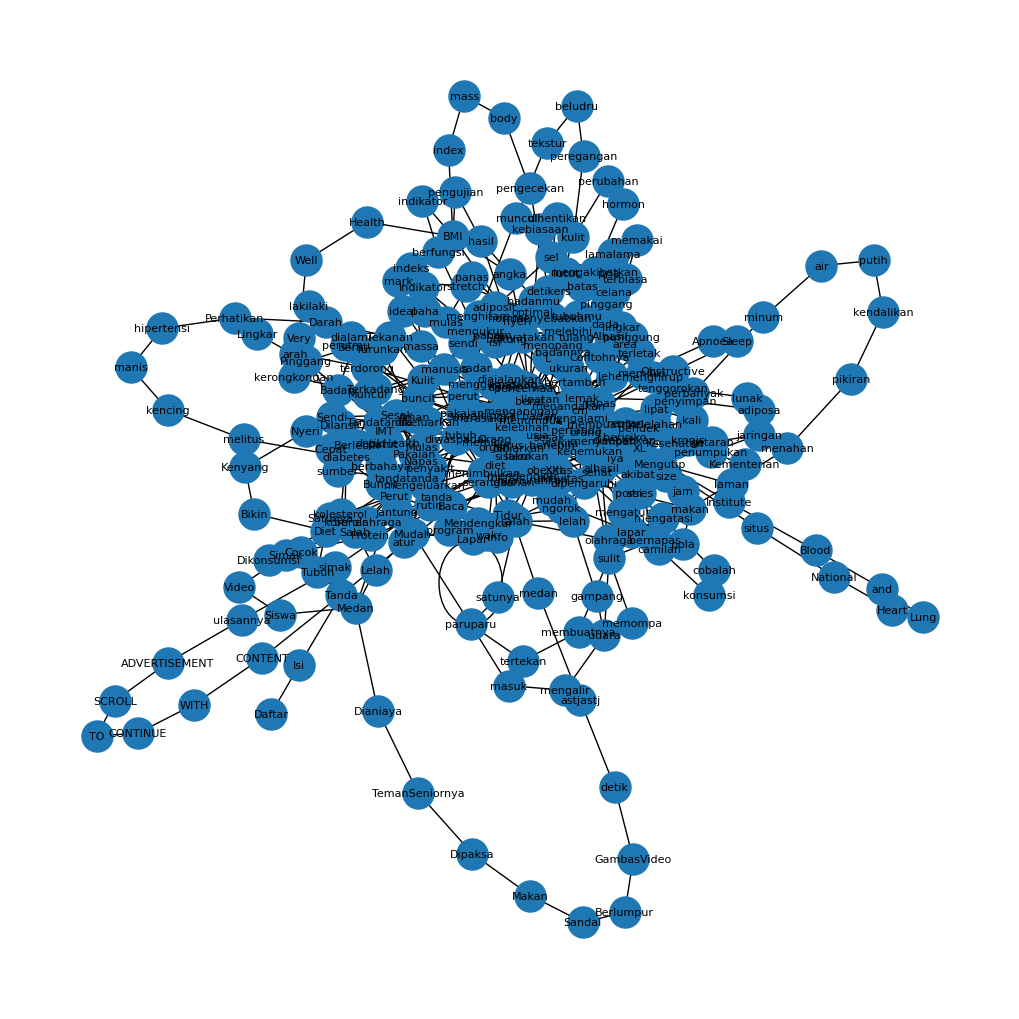

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert the DataFrame to a networkx graph
G = nx.from_pandas_adjacency(coo_df)

# Visualize the graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_size=8, node_size=500, font_color='black')
plt.show()

## Closeness, Eigenvector, Pagerank, Betweenness Centrality

In [8]:
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
pagerank_centrality = nx.pagerank(G)
betweenness_centrality = nx.pagerank(G)

## Closeness Centrality

Closeness centrality adalah sebuah metrik dalam analisis jaringan yang mengukur seberapa cepat suatu simpul (node) dapat diakses oleh simpul-simpul lain dalam jaringan. Dalam konteks graf, closeness centrality didefinisikan sebagai invers dari total jarak terpendek dari simpul tersebut ke semua simpul lainnya dalam jaringan. Dengan kata lain, simpul dengan closeness centrality yang tinggi berarti lebih mudah diakses atau lebih dekat secara struktural dengan simpul-simpul lainnya dalam jaringan.

Formula closeness centrality untuk simpul  dalam sebuah graf terhubung adalah sebagai berikut:
$C(u) = \frac{1}{\sum_{v=1}^{n} d(u, v)}$


Dimana:

- $C(u)$ adalah closeness centrality dari node $u$


- $d(u,v)$  adalah jarak terpendek antara node $u$ dan $v$

In [9]:
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

print("Closeness Similarity Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_closeness:
    print(f"{node}: {score}")

# Tampilkan 3 kata teratas dari nilai tertinggi
top_3_nodes = sorted_closeness[:3]

print("Tiga Kata Teratas dari Nilai Tertinggi Closeness Centrality:")
for node, _ in top_3_nodes:
    print(f"Kata: {node}")

Closeness Similarity Scores (Dari Tertinggi ke Terendah):
berat: 0.3150384193194292
tubuh: 0.31263616557734203
diet: 0.3116178067318133
badan: 0.3040254237288136
mengalami: 0.3033826638477801
perut: 0.2907801418439716
kelebihan: 0.28786359077231694
berlebih: 0.2833168805528134
menumpuk: 0.281648675171737
lemak: 0.2733333333333333
disebabkan: 0.2704995287464656
tanda: 0.26948356807511736
buncit: 0.2692307692307692
Perut: 0.2689784442361762
merasakan: 0.2669767441860465
kurus: 0.26648096564531104
kegemukan: 0.2662337662337662
orang: 0.26378676470588236
memicu: 0.26330275229357797
organ: 0.26138433515482695
dibiarkan: 0.2601994560290118
lakukan: 0.2601994560290118
salah: 0.2585585585585586
tandatanda: 0.2585585585585586
sinyal: 0.257168458781362
wanita: 0.25693822739480754
dinyatakan: 0.2567084078711986
leher: 0.256478999106345
sesak: 0.256021409455843
diwaspadai: 0.2551111111111111
melebihi: 0.2546583850931677
mudah: 0.2546583850931677
lipatan: 0.25353356890459366
menurunkan: 0.251975417

## Pagerank Centrality


PageRank centrality adalah suatu metode untuk mengukur pentingnya simpul (node) dalam suatu jaringan berbasis graf. Metode ini awalnya dikembangkan oleh Larry Page dan Sergey Brin untuk menilai relevansi halaman web dalam mesin pencari Google, dan kemudian diadopsi dalam analisis jaringan umumnya. PageRank centrality mengukur seberapa penting atau otoritatif suatu simpul dengan memperhitungkan jumlah dan kualitas koneksi yang dimilikinya. Intinya, simpul-simpul yang dihubungkan dengan simpul lain yang juga memiliki keterhubungan yang tinggi akan mendapatkan skor PageRank yang lebih tinggi.



Rumus umum untuk menghitung nilai PageRank  dalam sebuah graf adalah:
$PR(A) = (1-d) + d \left( \frac{PR(T1)}{C(T1)} + \frac{PR(T2)}{C(T2)} + ... + \frac{PR(Tn)}{C(Tn)} \right)$



- $PR(A)$ adalah PageRank dari halaman $A$.

- $PR(T1)$ sampai $PR(Tn)$ adalah PageRank dari halaman $T1$ sampai $Tn$ yang mengarah ke halaman $A$ (yaitu halaman yang memiliki tautan ke $A$).

- $C(T1)$ sampai $C(Tn)$ adalah jumlah tautan keluar dari halaman $T1$ sampai $Tn$.

- $d$ adalah faktor damping, yang biasanya diatur ke 0.85.

berikut contoh hitung manual dari pagerank :
https://docs.google.com/spreadsheets/d/1v-Xs-6sDeWFsMoIyW-Jj5Tc70aHMDN4emdDBugFYykM/edit?usp=sharing

In [10]:
sorted_pagerank = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)

print("Pagerank Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_pagerank:
    print(f"{node}: {score}")

# Tampilkan 3 kata teratas dari nilai tertinggi
top_3_nodes = sorted_pagerank[:3]

print("Tiga Kata Teratas dari Nilai Tertinggi Pagerank Centrality:")
for node, _ in top_3_nodes:
    print(f"Kata: {node}")

Pagerank Scores (Dari Tertinggi ke Terendah):
berat: 0.02952705786829349
badan: 0.025019298651469356
tubuh: 0.01898952733434267
diet: 0.018617343279714076
mengalami: 0.014868381103905676
lemak: 0.013215508380671336
perut: 0.011701896527458228
berlebih: 0.011612888141665731
disebabkan: 0.009859687942385686
kelebihan: 0.008673844216809846
Perut: 0.008556119246337717
BMI: 0.007581128566223924
buncit: 0.0075399453436114545
kegemukan: 0.0075224247907813985
leher: 0.007240905709912544
tandatanda: 0.007202458634976008
menyebabkan: 0.006801188334731419
Diet: 0.00646470495909619
nyeri: 0.006168975042778332
Mudah: 0.006053200905028677
makan: 0.0060322930420984465
Baca: 0.006010115432036945
orang: 0.005928300576252811
lingkar: 0.005924998693820129
Sesak: 0.005912438916751671
pinggang: 0.005849468867774441
Tanda: 0.005818892133867952
melebihi: 0.005708327135637103
detikers: 0.005682856009246752
sulit: 0.005615360087765234
paruparu: 0.005536610203587251
bertambah: 0.005414549901957124
menumpuk: 0.0

## Eigenvector Centrality

Eigenvector centrality adalah metode pengukuran kepentingan simpul dalam suatu jaringan yang mempertimbangkan kualitas koneksi dari simpul tersebut. Pendekatan ini memberikan bobot yang lebih tinggi pada simpul yang terhubung dengan simpul-simpul lain yang juga memiliki kepentingan tinggi. Dengan kata lain, simpul dengan eigenvector centrality yang tinggi tidak hanya memiliki banyak koneksi, tetapi juga terhubung dengan simpul-simpul penting dalam jaringan.

Eigenvector centrality dihitung berdasarkan nilai eigen dari matriks adjasensi atau matriks berbobot yang merepresentasikan struktur jaringan. Nilai eigen ini memberikan informasi tentang distribusi kepentingan simpul dalam jaringan. Simpul dengan nilai eigen yang tinggi cenderung terhubung dengan simpul-simpul lain yang juga memiliki nilai eigen yang tinggi.

Rumus umum untuk menghitung eigenvector centrality dalam suatu jaringan adalah sebagai berikut:

$x_v = \frac{1}{\lambda} \sum_{t \in M(v)} x_t$


- $x_v$ adalah eigenvector centrality dari simpul $v$.

- $M(v)$ adalah set simpul yang berdekatan dengan $v$

- $x_t$​ adalah eigenvector centrality dari simpul $t$.

- λ adalah konstanta.

In [11]:
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

print("Eigenvector Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_eigenvector:
    print(f"{node}: {score}")

# Tampilkan 3 kata teratas dari nilai tertinggi
top_3_nodes = sorted_eigenvector[:3]

print("Tiga Kata Teratas dari Nilai Tertinggi Pagerank Centrality:")
for node, _ in top_3_nodes:
    print(f"Kata: {node}")


Eigenvector Scores (Dari Tertinggi ke Terendah):
berat: 0.3497090233383761
diet: 0.33448421102598297
badan: 0.29562355117553923
tubuh: 0.2949743087405866
mengalami: 0.21971805191946744
perut: 0.18651550105984946
berlebih: 0.17274610732881998
lemak: 0.16028752713992314
menumpuk: 0.15689188694097128
kelebihan: 0.1540008182053825
tanda: 0.13853991911575955
memicu: 0.1274483371851143
buncit: 0.12163095481258092
disebabkan: 0.1129314422436539
sinyal: 0.10925681715000252
kurus: 0.10843510876342032
dibiarkan: 0.10379535082548239
lakukan: 0.10379535082548239
usia: 0.09790146049282487
Perut: 0.0968036092240765
kegemukan: 0.09235427533432652
merasakan: 0.09180944496246633
organ: 0.09155647173219782
salah: 0.08721896901330561
orang: 0.08531636670060946
diwaspadai: 0.08406896921090472
leher: 0.08130747502202638
dinyatakan: 0.0747574497567344
melebihi: 0.07461038192574233
tandatanda: 0.07454619775391415
wanita: 0.0729610473177012
ukuran: 0.0680268105994056
menurunkan: 0.06628442379003335
mengeluark

## Betweenes Centrality


Betweenness centrality adalah metode pengukuran kepentingan simpul dalam suatu jaringan berbasis graf yang mengukur seberapa sering suatu simpul menjadi perantara (intermediary) pada lintasan terpendek antara dua simpul lain dalam jaringan. Dengan kata lain, simpul dengan betweenness centrality yang tinggi cenderung memiliki peran penting dalam menghubungkan bagian-bagian yang berbeda dalam jaringan.
rumusnya sebagai berikut:

$C_B(v) =\sum_{s,t \in V} \frac{\sigma(s, t|v)}{\sigma(s, t)}$

Dimana:

- $C_B​(v)$ adalah betweenness centrality dari simpul $v$

- $V$ adalah set simpul dalam jaringan

- $σ(s,t)$ adalah jumlah shortest path dari simpul $s$ ke simpul $t$

- $σ(s,t∣v)$ adalah jumlah shortest path dari simpul $s$ ke simpul $t$ yang melewati simpul $v$

In [12]:
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

print("betweenness Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_betweenness:
    print(f"{node}: {score}")

# Tampilkan 3 kata teratas dari nilai tertinggi
top_3_nodes = sorted_betweenness[:3]

print("Tiga Kata Teratas dari Nilai Tertinggi betweenness Centrality:")
for node, _ in top_3_nodes:
    print(f"Kata: {node}")


betweenness Scores (Dari Tertinggi ke Terendah):
berat: 0.02952705786829349
badan: 0.025019298651469356
tubuh: 0.01898952733434267
diet: 0.018617343279714076
mengalami: 0.014868381103905676
lemak: 0.013215508380671336
perut: 0.011701896527458228
berlebih: 0.011612888141665731
disebabkan: 0.009859687942385686
kelebihan: 0.008673844216809846
Perut: 0.008556119246337717
BMI: 0.007581128566223924
buncit: 0.0075399453436114545
kegemukan: 0.0075224247907813985
leher: 0.007240905709912544
tandatanda: 0.007202458634976008
menyebabkan: 0.006801188334731419
Diet: 0.00646470495909619
nyeri: 0.006168975042778332
Mudah: 0.006053200905028677
makan: 0.0060322930420984465
Baca: 0.006010115432036945
orang: 0.005928300576252811
lingkar: 0.005924998693820129
Sesak: 0.005912438916751671
pinggang: 0.005849468867774441
Tanda: 0.005818892133867952
melebihi: 0.005708327135637103
detikers: 0.005682856009246752
sulit: 0.005615360087765234
paruparu: 0.005536610203587251
bertambah: 0.005414549901957124
menumpuk: 